In [15]:
import numpy as np
import pandas as pd
import seaborn as sns

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

from keras.regularizers import l1

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, label_ranking_loss, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt

import datetime

import plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.graph_objs import Data,Figure

from sklearn.preprocessing import  StandardScaler, MinMaxScaler



In [16]:
# PREPROCESSING

# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# open the csv dataset
df = pd.read_csv("kddcup.data_10_percent.gz",compression='gzip',header=None, names = col_names)

# Remove smurf and neptune attacks
df = df[df.label != 'smurf.']
df = df[df.label != 'neptune.']

# Remove duplicates
df.drop_duplicates(subset=None, keep='first', inplace=True)


#data = df.drop("label", axis=1) #labels serviront pour évaluer la qualité du modèle
target = df["label"]



# One hot encoding
cols_to_dummify = ['protocol_type','service','flag']
data_dummy = pd.get_dummies(df, columns=cols_to_dummify, prefix=cols_to_dummify)
target_dummy = pd.get_dummies(target)
target_categories = target_dummy.columns


# Splitting train/test
RANDOM_SEED=87
X = data_dummy.values
y = target_dummy.values
X_train, X_test = train_test_split(data_dummy, test_size=0.2, random_state = RANDOM_SEED)

#X_train = X_train[X_train['label'] == 'normal.' ] # Only train on normal data (no intrusion)
X_test = X_test[X_test['label'] != 'smurf.']
y_train = X_train['label'] 
ylabel_train= (y_train != 'normal.')
X_train = X_train.drop(['label'], axis=1)
y_test  = X_test['label']
X_test  = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test  = X_test.values

# Standardize/Normalize dataset?
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('Training data size   :', X_train.shape)
print('Validation (test) data size :', X_test.shape)
data_dummy.head()

Training data size   : (74500, 109)
Validation (test) data size : (18625, 109)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,235,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,219,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,217,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 100 arbres et 200 échantillons par arbres est 0.50
threshold correspondant 0.50


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 200 arbres et 400 échantillons par arbres est 0.50
threshold correspondant 0.46


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 300 arbres et 600 échantillons par arbres est 0.63
threshold correspondant 0.46


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 400 arbres et 800 échantillons par arbres est 0.69
threshold correspondant 0.46


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 500 arbres et 1000 échantillons par arbres est 0.56
threshold correspondant 0.47


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 600 arbres et 1200 échantillons par arbres est 0.61
threshold correspondant 0.46


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 700 arbres et 1400 échantillons par arbres est 0.65
threshold correspondant 0.45


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 800 arbres et 1600 échantillons par arbres est 0.62
threshold correspondant 0.46


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 900 arbres et 1800 échantillons par arbres est 0.61
threshold correspondant 0.45


/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



le meilleur f1 score pour 1000 arbres et 2000 échantillons par arbres est 0.59
threshold correspondant 0.44
f1 max= 0.69
threshold_corres= 0.46
meilleur nombre d arbres= 400
meilleur nombre d échantillons= 800


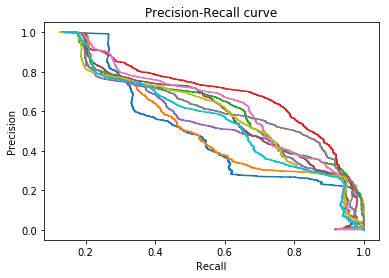

In [18]:
# MODEL BUILDING
imax=0
jmax=0
f1_max=0

for i in range(100,1001,100):
    j=2*i

    rng = np.random.RandomState(i)


    # training the model
    clf = IsolationForest(behaviour='new', max_samples=j, random_state=rng)
    clf.fit(X_train)
    score = -clf.score_samples(X_train)

    # Precision recall curve
    precision, recall, thresholds = precision_recall_curve(ylabel_train, score)

    # ROC curve
    fpr, tpr, thresholds2 = roc_curve(ylabel_train, score)

    # F1 score
    f1_score = 2*(precision*recall)/(precision+recall)

    meilleur_f1_score = max(f1_score)
    position = np.where(f1_score==meilleur_f1_score)
    print('le meilleur f1 score pour',i,'arbres et',j,'échantillons par arbres est',"%.2f" % meilleur_f1_score)

    # meilleur threshold
    threshold = thresholds[position]
    print('threshold correspondant',"%.2f" % threshold)

    # PLOT precision recall curve
    plt.plot(precision, recall)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')


    #PLOT roc curve
    #plt.plot(fpr, tpr)
    #plt.xlabel('False positive rate')
    #plt.ylabel('True positive rate')
    #plt.title('ROC curve')
    #plt.show()

    # predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # y_pred_outliers = clf.predict(X_outliers)
    # Meilleurs paramètres
    if meilleur_f1_score>f1_max:
        f1_max=meilleur_f1_score
        imax=i
        jmax=j
        threshold_corres = threshold

print('f1 max=',"%.2f" % f1_max)
print('threshold_corres=',"%.2f" % threshold_corres)
print('meilleur nombre d arbres=',imax)
print('meilleur nombre d échantillons=',jmax)
plt.show()
        

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



meilleur f1 score =  0.69
threshold correspondant pour le modèle =  0.46


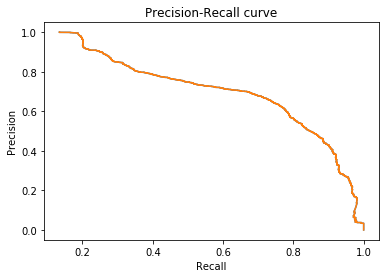

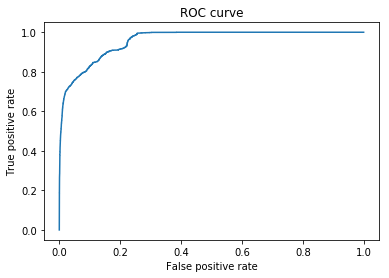

Confusion matrix, without normalization
[[69247  1059]
 [ 1407  2787]]
Normalized confusion matrix
[[0.98493727 0.01506273]
 [0.33547926 0.66452074]]


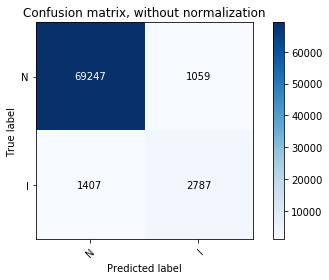

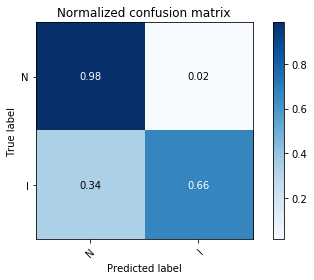

matrice de confusion =
 [[69247  1059]
 [ 1407  2787]]
precision =  0.72
recall =  0.66
aire sous la courbe roc =  0.82


In [26]:
# Entrainement du modèle avec les paramètres trouvés


rng = np.random.RandomState(imax)
        
# training the model
clf = IsolationForest(max_samples=jmax, random_state=rng)
clf.fit(X_train)
score = -clf.score_samples(X_train)


# Precision recall curve
precision, recall, thresholds = precision_recall_curve(ylabel_train, score)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show

# ROC curve
fpr, tpr, thresholds1 = roc_curve(ylabel_train, score)

# F1 score
f1_score = 2*(precision*recall)/(precision+recall)

meilleur_f1_score = max(f1_score)
position = np.where(f1_score==meilleur_f1_score)
print('meilleur f1 score = ', "%.2f" % meilleur_f1_score)

# meilleur threshold
threshold_train = thresholds[position]
print('threshold correspondant pour le modèle = ', "%.2f" % threshold_train)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()
#PLOT roc curve
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#Prediction with calculated best threshold:
Y_predicted = (score>threshold_train)

#Confusion matrix
#Confusion matrix
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels="NI", yticklabels="NI",
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



# Plot non-normalized confusion matrix
plot_confusion_matrix(ylabel_train, Y_predicted,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ylabel_train, Y_predicted, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print('matrice de confusion =\n',confusion_matrix(ylabel_train, Y_predicted,))

#precision= TP/(TP+FP)= proportion des classés positifs qui en sont vraiment
print('precision = ',"%.2f" % precision_score(ylabel_train, Y_predicted,))

#recall= TP/(TP+FN)= proportion 
print('recall = ',"%.2f" % recall_score(ylabel_train, Y_predicted,))

#roc_score
print('aire sous la courbe roc = ',"%.2f" % roc_auc_score(ylabel_train, Y_predicted,))





meilleur f1_score =  0.70
threshold correspondant au meilleur f1_score =  0.46


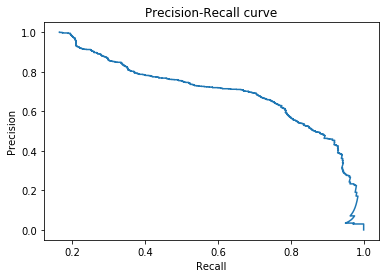

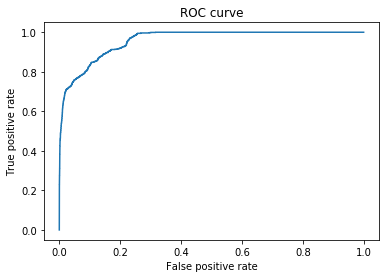

Confusion matrix, without normalization
[[17273   253]
 [  375   724]]
Normalized confusion matrix
[[0.99 0.01]
 [0.34 0.66]]


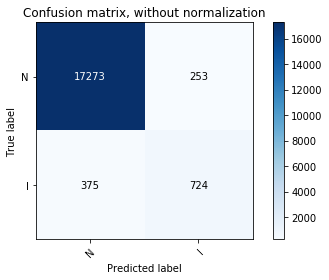

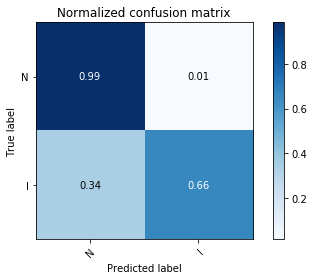

precision =  0.74
recall =  0.66
aire sous la courbe roc =  0.82


In [29]:
#Calcul des scores avec le modèle entrainé
score = -clf.score_samples(X_test)

# Precision recall curve
precision, recall, thresholds = precision_recall_curve((y_test!="normal."), score)

# ROC curve
fpr, tpr, thresholds1 = roc_curve((y_test!="normal."), score)

# F1 score
f1_score = 2*(precision*recall)/(precision+recall)

meilleur_f1_score = max(f1_score)
position = np.where(f1_score==meilleur_f1_score)
np.set_printoptions(precision=2)

print('meilleur f1_score = ',"%.2f" % meilleur_f1_score)

# meilleur threshold
threshold = thresholds[position]
print('threshold correspondant au meilleur f1_score = ',"%.2f" % threshold)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

#PLOT roc curve
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#Prediction with calculated best threshold:
Y_predicted = (score>threshold_train)

#Confusion matrix
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels='NI', yticklabels='NI',
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



# Plot non-normalized confusion matrix
plot_confusion_matrix((y_test!="normal."), Y_predicted,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix((y_test!="normal."), Y_predicted, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#precision= TP/(TP+FP)= proportion des classés positifs qui en sont vraiment
print('precision = ',"%.2f" % precision_score((y_test!="normal."), Y_predicted,))

#recall= TP/(TP+FN)= proportion 
print('recall = ',"%.2f" % recall_score((y_test!="normal."), Y_predicted,))

#roc_score
print('aire sous la courbe roc = ',"%.2f" % roc_auc_score((y_test!="normal."), Y_predicted,))



/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/Users/Theo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



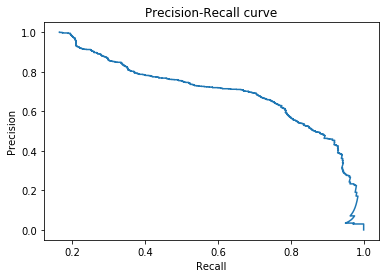

meilleur f1_score =  0.70
threshold correspondant au meilleur f1_score =  0.46


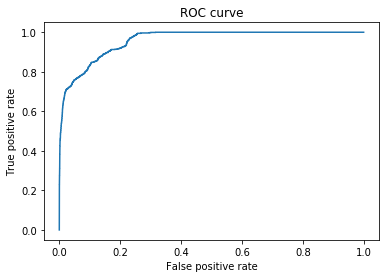

Confusion matrix, without normalization
[[17208   318]
 [  340   759]]
Normalized confusion matrix
[[0.98 0.02]
 [0.31 0.69]]


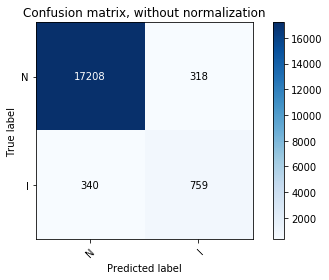

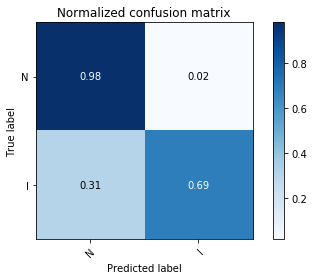

precision =  0.70
recall =  0.69
aire sous la courbe roc =  0.84


In [28]:
# MODEL BUILDING WITH DATA_TEST


rng = np.random.RandomState(imax)
        
clf2 = IsolationForest(max_samples=jmax, random_state=rng)
clf2.fit(X_test)
score2 = -clf.score_samples(X_test)


# Precision recall curve
precision, recall, thresholds = precision_recall_curve((y_test!="normal."), score)

# PLOT precision recall curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

# ROC curve
fpr, tpr, thresholds1 = roc_curve((y_test!="normal."), score)

# F1 score
f1_score = 2*(precision*recall)/(precision+recall)

meilleur_f1_score = max(f1_score)
position = np.where(f1_score==meilleur_f1_score)

print('meilleur f1_score = ',"%.2f" % meilleur_f1_score)

# meilleur threshold
threshold = thresholds[position]
print('threshold correspondant au meilleur f1_score = ',"%.2f" % threshold)

#PLOT roc curve
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#Prediction with calculated best threshold:
Y_predicted = (score>threshold)

#Confusion matrix
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels='NI', yticklabels='NI',
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



# Plot non-normalized confusion matrix
plot_confusion_matrix((y_test!="normal."), Y_predicted,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix((y_test!="normal."), Y_predicted, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#precision= TP/(TP+FP)= proportion des classés positifs qui en sont vraiment
print('precision = ',"%.2f" % precision_score((y_test!="normal."), Y_predicted,))

#recall= TP/(TP+FN)= proportion des positifs classés positifs
print('recall = ',"%.2f" % recall_score((y_test!="normal."), Y_predicted,))

#roc_score
print('aire sous la courbe roc = ',"%.2f" % roc_auc_score((y_test!="normal."), Y_predicted,))

